In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary NLTK data
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
import yfinance as yf
import talib
import numpy as np

def get_stock_data(ticker):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
df = get_stock_data("TCS.NS")  # Replace with your stock ticker
df.head()  # Display the first few rows


Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,,,
Date,,,,,,,,,,,,
2003-05-19,27.760592,27.760592,27.760592,27.760592,0,26.580723,27.760592,27.760592,28.443079,31.402638,27.760592,27.760592
2003-05-20,27.760592,27.760592,27.760592,27.760592,0,26.580723,27.760592,27.760592,28.404932,31.397892,27.760592,27.760592
2003-05-21,27.760592,27.760592,27.760592,27.760592,0,26.580723,27.760592,27.760592,28.352503,31.395090,27.760592,27.760592
2003-05-22,27.760592,27.760592,27.760592,27.760592,0,26.580723,27.760592,27.760592,28.309113,31.402050,27.760592,27.760592
2003-05-23,27.760592,27.760592,27.760592,27.760592,0,26.580723,27.760592,27.760592,28.257948,31.409011,27.760592,27.760592


In [31]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [32]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")

        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - loss: 0.0440 - learning_rate: 0.0010
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 8.6415e-04 - learning_rate: 0.0010
Epoch 11/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - loss: 8.5727e-04 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
RMSE: 138.20755249593304
MAE: 115.65838275203829
MAPE: 3.130949224668569
R^2 Score: 0.20132949496465868


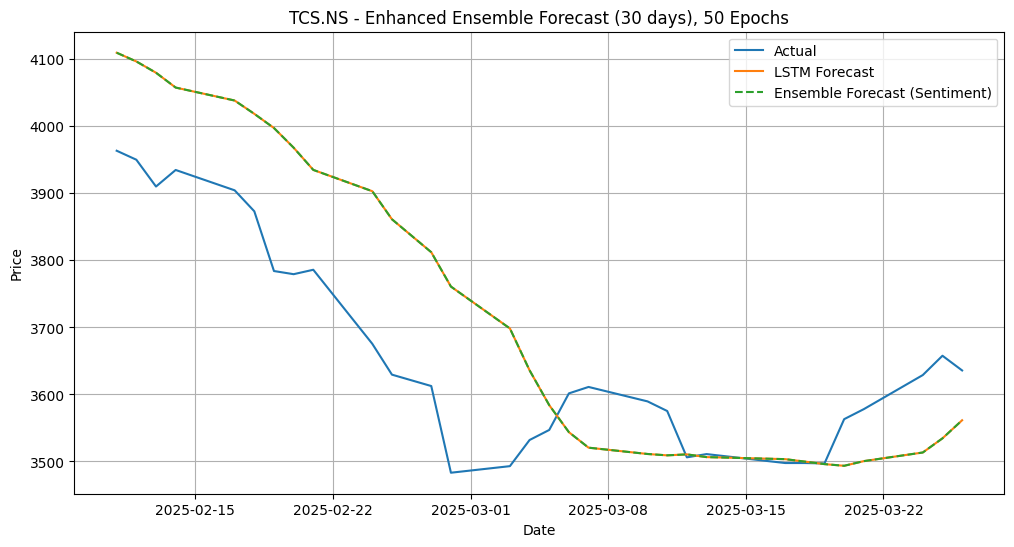

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - loss: 0.0311 - learning_rate: 0.0010
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 9.9409e-04 - learning_rate: 0.0010
Epoch 11/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
RMSE: 108.57758003863464
MAE: 92.87164230291518
MAPE: 2.51724297541747
R^2 Score: 0.5070709541166831


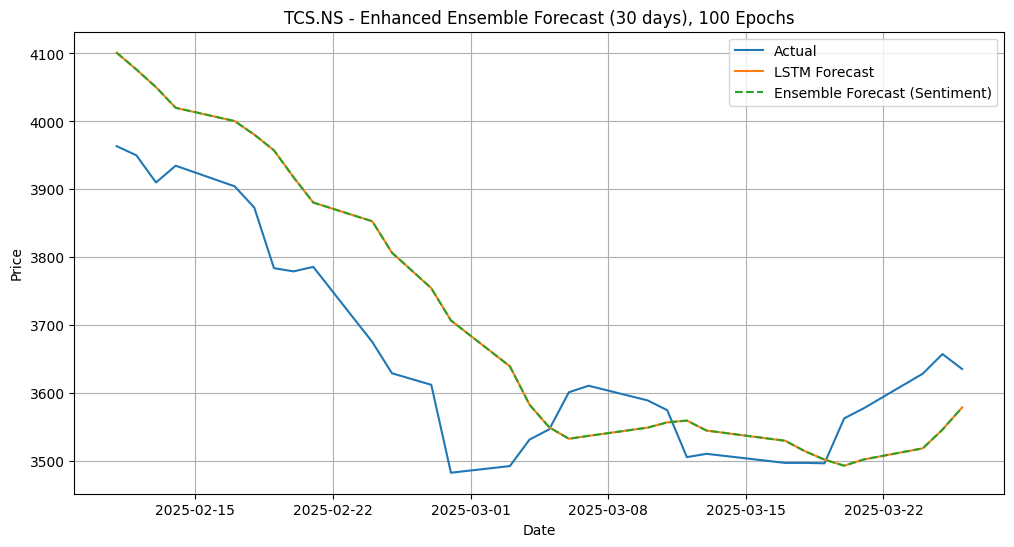

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 0.0638 - learning_rate: 0.0010
Epoch 2/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 3/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 4/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 7/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 8/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 10/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0011 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
RMSE: 117.9235943504603
MAE: 101.3414151865988
MAPE: 2.7501655632431388
R^2 Score: 0.41855919060247915


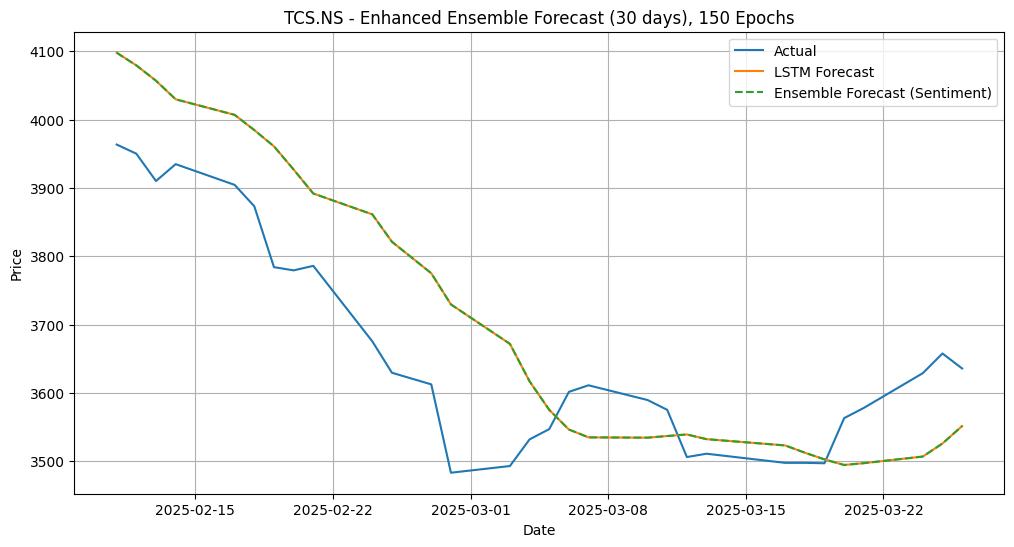

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 0.0268 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 8/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 9.8590e-04 - learning_rate: 0.0010
Epoch 10/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
RMSE: 111.84364444225135
MAE: 94.55741270199292
MAPE: 2.5682943931832702
R^2 Score: 0.47696986227154536


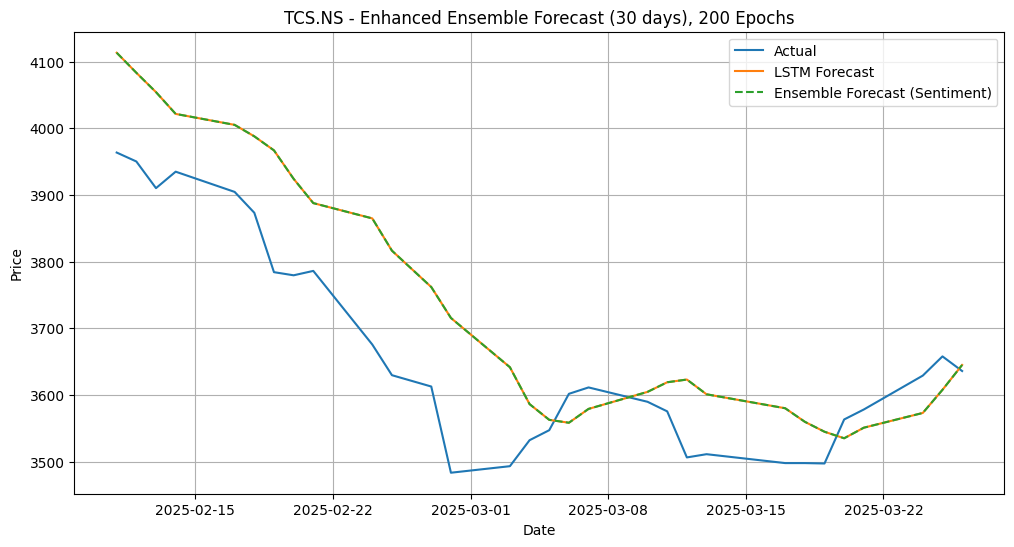

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - loss: 0.0456 - learning_rate: 0.0010
Epoch 2/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 3/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 4/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 9/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 9.8402e-04 - learning_rate: 0.0010
Epoch 10/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 8.8605e-04 - learning_rate: 0.0010
Epoch 11/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
RMSE: 94.1879282139524
MAE: 80.01066737229469
MAPE: 2.1762043864889042
R^2 Score: 0.62906776002982


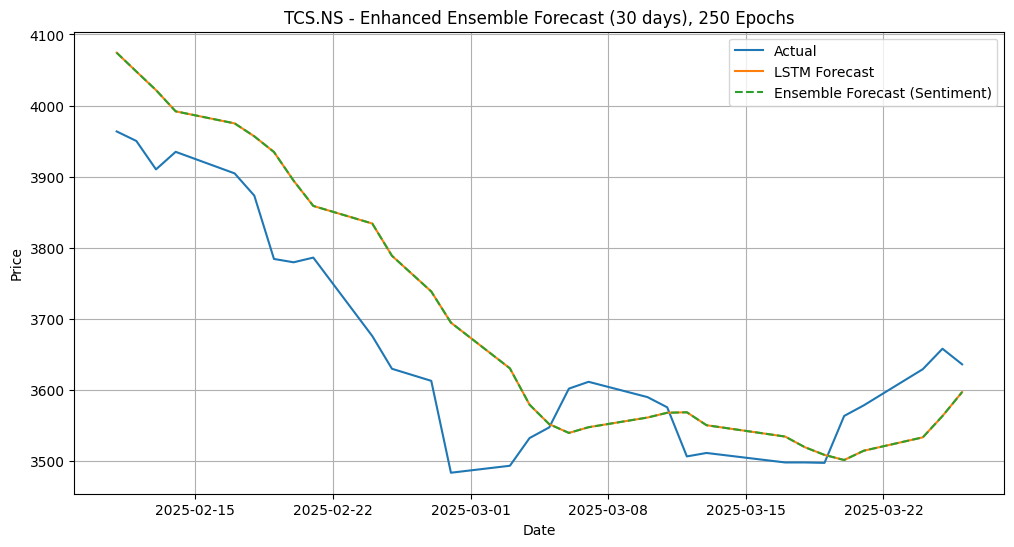

In [35]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - loss: 0.0295 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 9.5424e-04 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 8.1589e-04 - learning_rate: 0.0010
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 9.2320e-04 - learning_rate: 0.0010
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 6.3749e-04 - learning_rate: 0.0010
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 7.9561e-04 - learning_rate: 0.0010
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
RMSE: 28.911031375624056
MAE: 23.50364909582839
MAPE: 1.9159197262173744
R^2 Score: 0.17637618787837273


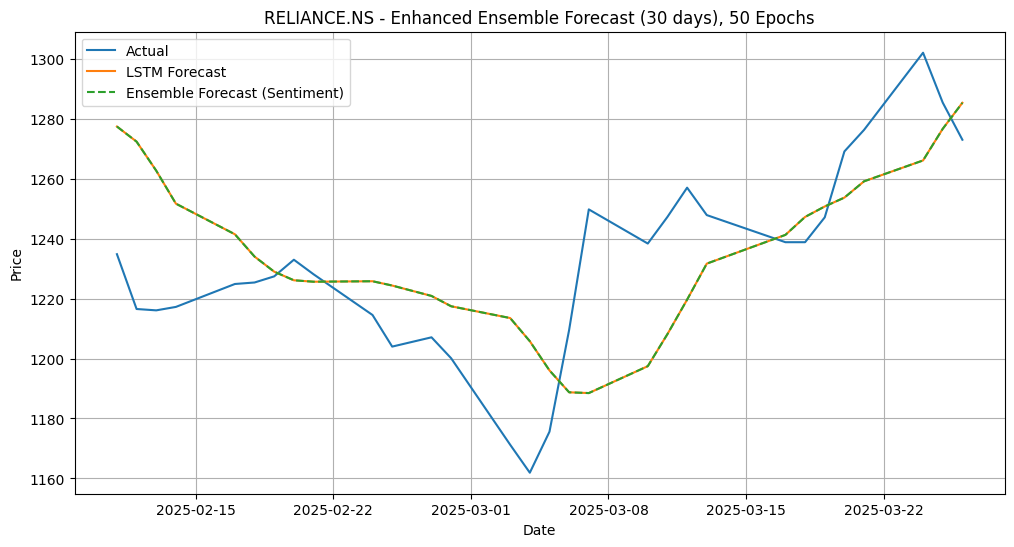

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - loss: 0.0268 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 9.8741e-04 - learning_rate: 0.0010
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 9.1590e-04 - learning_rate: 0.0010
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 6.9929e-04 - learning_rate: 0.0010
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 9.1328e-04 - learning_rate: 0.0010
Epoch 10/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 6.1583e-04 - learning_rate: 0.0010
Epoch 11/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
RMSE: 31.134632309753027
MAE: 24.5989594009781
MAPE: 1.9800104968487893
R^2 Score: 0.04481123291124667


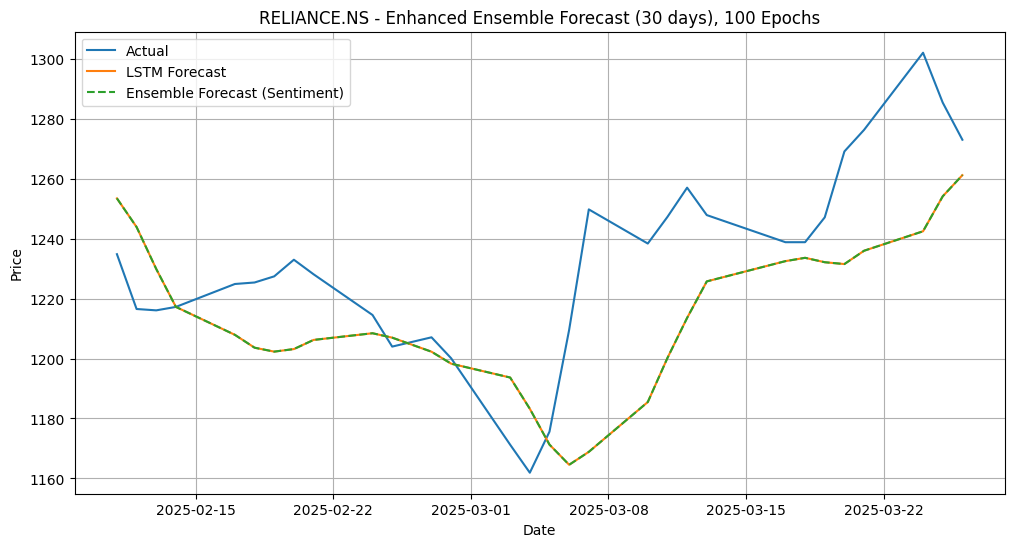

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 0.0338 - learning_rate: 0.0010
Epoch 2/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 4/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 6/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 7/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 9.8970e-04 - learning_rate: 0.0010
Epoch 8/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 6.8575e-04 - learning_rate: 0.0010
Epoch 10/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 6.9146e-04 - learning_rate: 0.0010
Epoch 11/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
RMSE: 26.164476951187055
MAE: 21.184327784927497
MAPE: 1.7264325345510114
R^2 Score: 0.3254318395406307


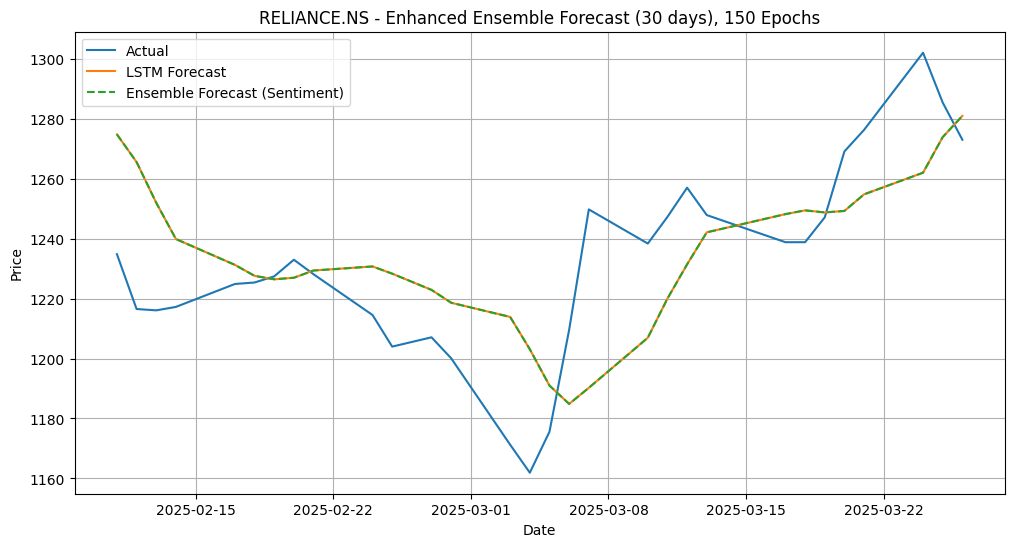

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 0.0256 - learning_rate: 0.0010
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 9.9441e-04 - learning_rate: 0.0010
Epoch 7/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 9.2074e-04 - learning_rate: 0.0010
Epoch 8/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 8.6180e-04 - learning_rate: 0.0010
Epoch 9/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 8.0840e-04 - learning_rate: 0.0010
Epoch 10/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 11/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
RMSE: 23.035474962026896
MAE: 18.014888048620932
MAPE: 1.460216701002218
R^2 Score: 0.477127180234613


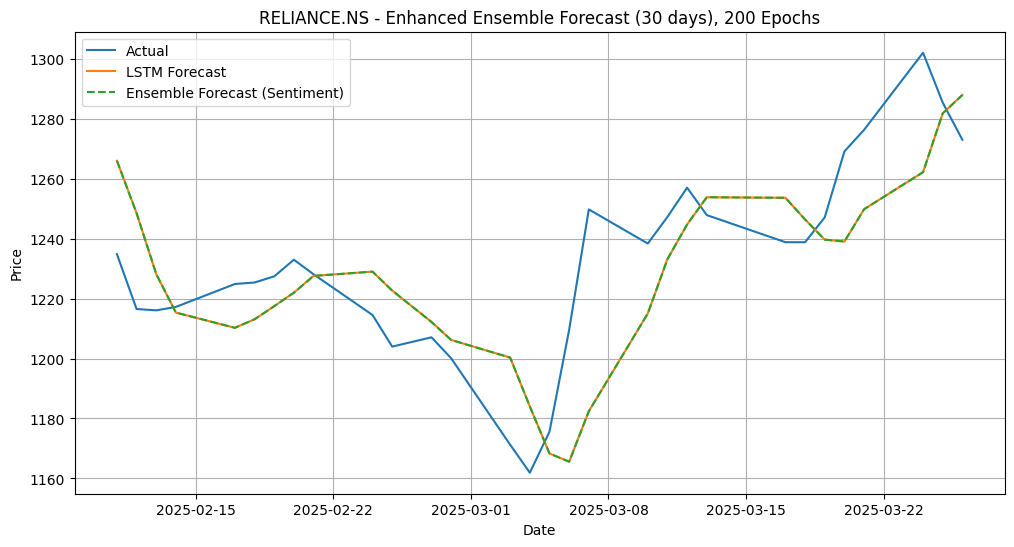

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 0.0137 - learning_rate: 0.0010
Epoch 2/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 3/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 4/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 9.9099e-04 - learning_rate: 0.0010
Epoch 5/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 9.1734e-04 - learning_rate: 0.0010
Epoch 6/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 7.7003e-04 - learning_rate: 0.0010
Epoch 7/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 7.8860e-04 - learning_rate: 0.0010
Epoch 8/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 7.7499e-04 - learning_rate: 0.0010
Epoch 9/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 7.1637e-04 - learning_rate: 0.0010
Epoch 10/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 6.7619e-04 - learning_rate: 0.0010
Epoch 11/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
RMSE: 23.530613892443455
MAE: 17.838951146576065
MAPE: 1.4415279485056467
R^2 Score: 0.4544076911447158


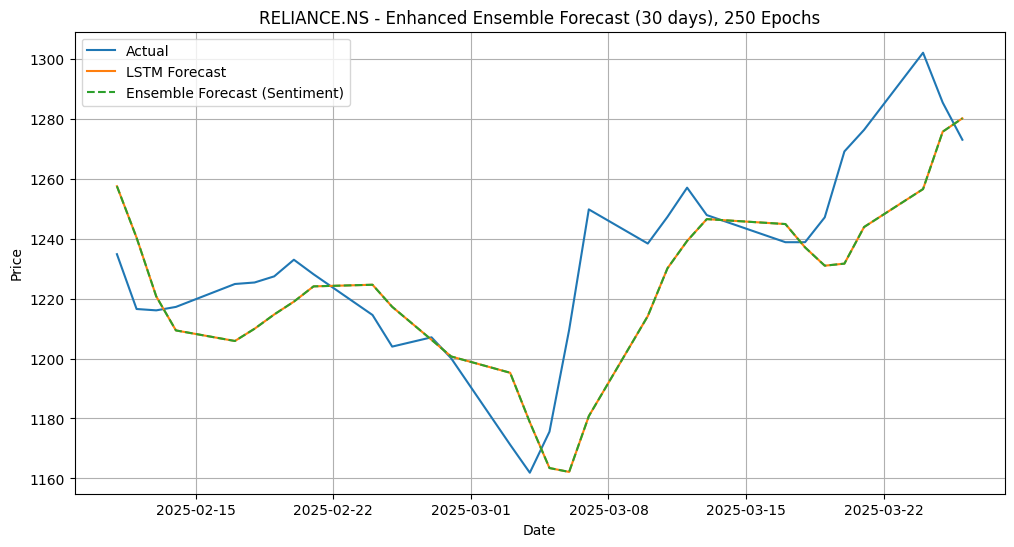

In [36]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0403 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 9.2523e-04 - learning_rate: 0.0010
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.6793e-04 - learning_rate: 0.0010
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0012 - learning_r

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 530.68
MAE: 473.12
MAPE: 2.08%
R² Score: -0.6156

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0498 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.4458e-04 - learning_rate: 0.0010
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0011 - learning_rate:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 631.19
MAE: 542.87
MAPE: 2.35%
R² Score: -0.9732

Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0488 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0046 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0010 - learning_rate: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
📊 Performance Metrics for ^NSEBANK:
RMSE: 731.16
MAE: 626.70
MAPE: 1.27%
R² Score: 0.4738



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEAUTO. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEIT. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMETAL. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEENERGY. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEPHARMA. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEFMCG. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


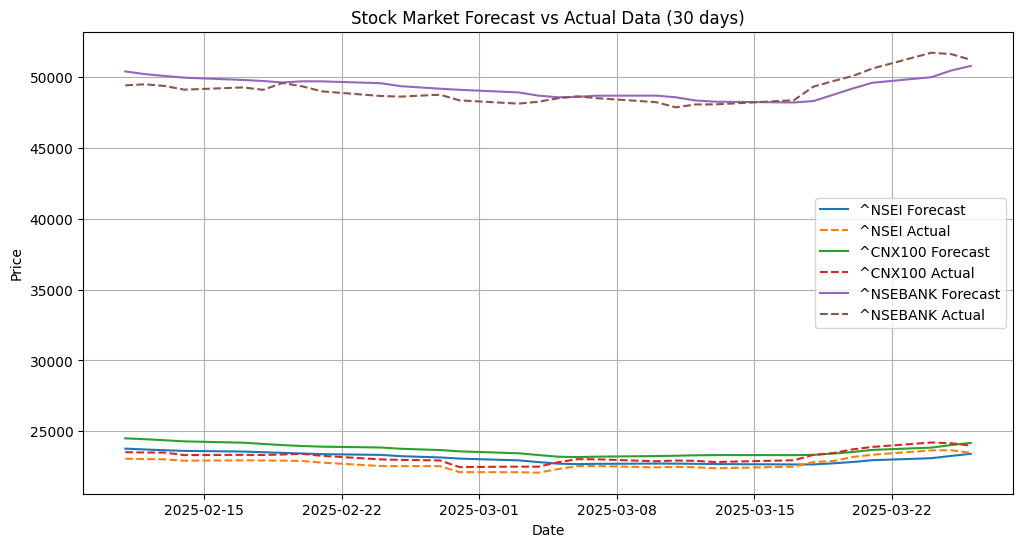

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0530 - learning_rate: 0.0010
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0012 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 345.97
MAE: 301.79
MAPE: 1.32%
R² Score: 0.3133

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0393 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.4515e-04 - learning_rate: 0.0010
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 7.7148e-04 - learning_rate: 0.0010
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.2790e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 572.12
MAE: 488.84
MAPE: 2.11%
R² Score: -0.6211

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0767 - learning_rate: 0.0010
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0014 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed dow

📊 Performance Metrics for ^NSEBANK:
RMSE: 1380.43
MAE: 1244.14
MAPE: 2.55%
R² Score: -0.8756

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...
⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...
⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


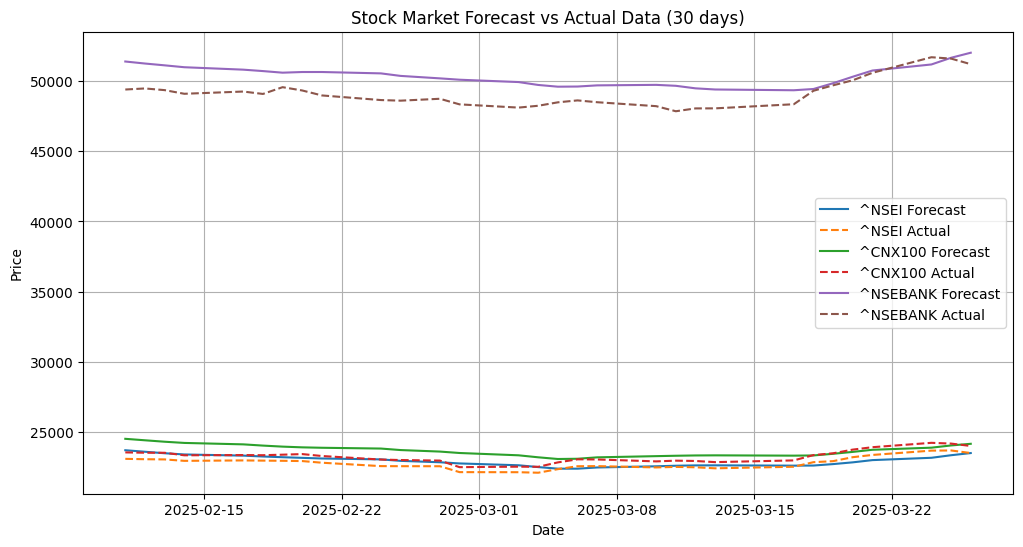

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0440 - learning_rate: 0.0010
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.7061e-04 - learning_rate: 0.0010
Epoch 10/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.8508e-04 - learning_rate: 0.0010
Epoch 11/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.7407e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 503.98
MAE: 446.01
MAPE: 1.96%
R² Score: -0.4571

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0329 - learning_rate: 0.0010
Epoch 2/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 3/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 4/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 5/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 6/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 7/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 9.3061e-04 - learning_rate: 0.0010
Epoch 8/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 8.3064e-04 - learning_rate: 0.0010
Epoch 9/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 6.7316e-04 - learning_rate: 0.0010
Epoch 10/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 9.3714e-04 - learning_rate: 0.0010
Epoch 11/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 383.54
MAE: 333.19
MAPE: 1.43%
R² Score: 0.2714

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0604 - learning_rate: 0.0010
Epoch 2/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0078 - learning_rate: 0.0010
Epoch 3/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 4/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 5/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 6/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 7/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0013 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


📊 Performance Metrics for ^NSEBANK:
RMSE: 1201.74
MAE: 1078.67
MAPE: 2.21%
R² Score: -0.4215

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...


ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEREALTY. Skipping...
⚠️ Warning: No data found for ^NSEINFRA. Skipping...
⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


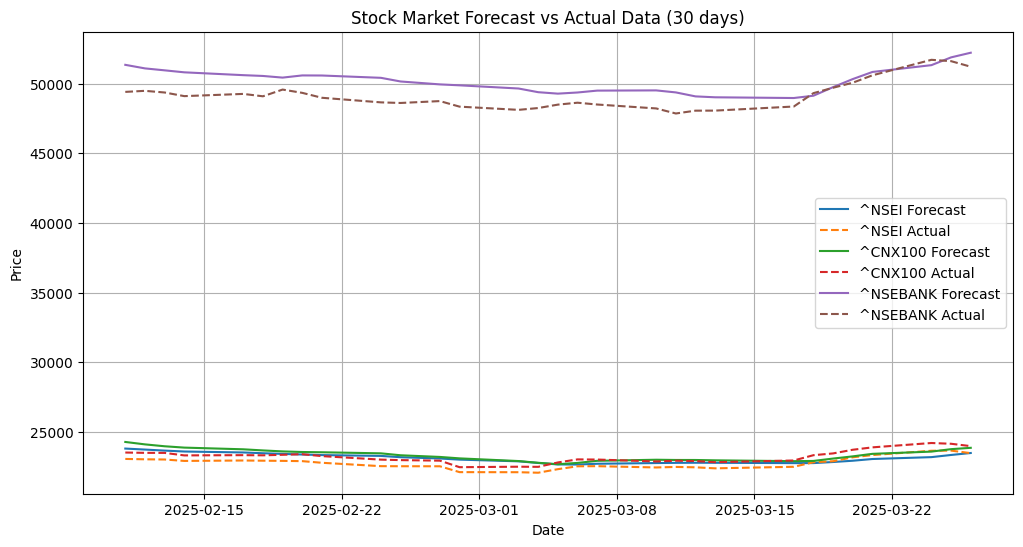

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0608 - learning_rate: 0.0010
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 7/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 7.9236e-04 - learning_rate: 0.0010
Epoch 11/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 7.1185e-04 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 320.89
MAE: 280.45
MAPE: 1.23%
R² Score: 0.4559

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0501 - learning_rate: 0.0010
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 9.6121e-04 - learning_rate: 0.0010
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 8.5975e-04 - learning_rate: 0.0010
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 9.1135e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 352.43
MAE: 270.88
MAPE: 1.15%
R² Score: 0.4357

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0458 - learning_rate: 0.0010
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 10/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 9.2816e-04 - learning_rate: 0.0010
Epoch 11/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0010 - lear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


📊 Performance Metrics for ^NSEBANK:
RMSE: 1082.87
MAE: 936.66
MAPE: 1.91%
R² Score: 0.0224

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEINFRA. Skipping...


ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


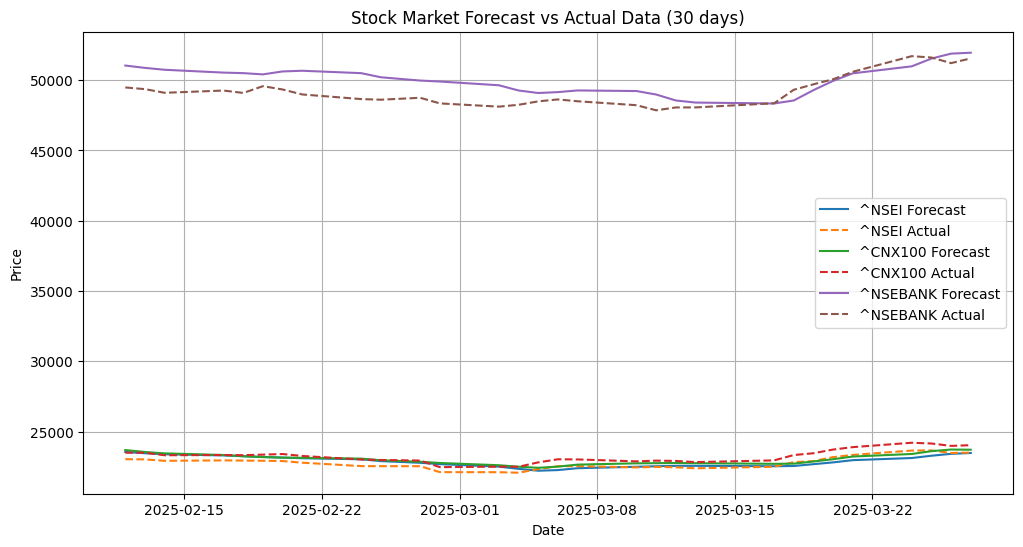

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0317 - learning_rate: 0.0010
Epoch 2/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 3/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 4/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 7/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.4183e-04 - learning_rate: 0.0010
Epoch 8/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 9/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 7.9942e-04 - learning_rate: 0.0010
Epoch 10/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.1077e-04 - learning_rate: 0.0010
Epoch 11/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 6.923

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 372.98
MAE: 320.63
MAPE: 1.41%
R² Score: 0.2784

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0576 - learning_rate: 0.0010
Epoch 2/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 3/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 4/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 7/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 8/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 9/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 11/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 9.0256e-04 - lear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 285.98
MAE: 234.46
MAPE: 1.00%
R² Score: 0.5950

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0474 - learning_rate: 0.0010
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 11/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0014 - learning

In [ ]:
nifty_indices = ['^NSEI', '^CNX100', '^NSEBANK', '^NSEAUTO', '^NSEIT', '^NSEMETAL', '^NSEENERGY', '^NSEPHARMA', '^NSEFMCG', '^NSEPSU', '^NSEREALTY', '^NSEINFRA', '^NSEMIDCAP', '^NSESMALLCAP']
forecast_multiple_indices(nifty_indices, epoch=50)
forecast_multiple_indices(nifty_indices, epoch=100)
forecast_multiple_indices(nifty_indices, epoch=150)
forecast_multiple_indices(nifty_indices, epoch=200)
forecast_multiple_indices(nifty_indices, epoch=250)
